# Modelos mixtos

Una guía divertida de modelos mixtos con sas

## Medidas repetidas

Guía adaptada de:
https://stats.idre.ucla.edu/r/seminars/repeated-measures-analysis-with-r/

### Ejemplo de datos de ejercicio y pulso

En este ejemplo se usan unos datos de personas a quienes se les midió el pulso al realizar cierto tipo de ejercicio en distintos periodos de tiempo. También se les asignó una dieta.

A continuación se leen los datos de internet y se les asigna unos formatos para que las gráficas y análisis se vean bien.

In [10]:
proc format;
value dieta
 1 = "Baja en grasas"
 2 = "Normal";
 value ejer
 1 = "Reposo"
 2 = "Caminar"
 3 = "Correr";
 value tiempo
 1 = "1 minuto"
 2 = "15 minutos"
 3 = "30 minutos";
run;

filename exer url "https://stats.idre.ucla.edu/stat/data/exer.csv";

data datos;
infile exer dlm = "," firstobs = 2;
input persona dieta ejercicio pulso tiempo;
format dieta dieta. ejercicio ejer. tiempo tiempo.;
label persona = "Individuo" dieta = "Tipo de dieta"
ejercicio = "Tipo de ejercicio" tiempo = "Intervalo de tiempo" pulso = "Pulso";
run;

proc print data = datos(obs = 12) noobs;
run;

persona,dieta,ejercicio,pulso,tiempo
1,Baja en grasas,Reposo,85,1 minuto
1,Baja en grasas,Reposo,85,15 minutos
1,Baja en grasas,Reposo,88,30 minutos
2,Baja en grasas,Reposo,90,1 minuto
2,Baja en grasas,Reposo,92,15 minutos
2,Baja en grasas,Reposo,93,30 minutos
3,Baja en grasas,Reposo,97,1 minuto
3,Baja en grasas,Reposo,97,15 minutos
3,Baja en grasas,Reposo,94,30 minutos
4,Baja en grasas,Reposo,80,1 minuto


Un análisis descriptivo podría ayudar a visualizar cómo se comportan los datos.


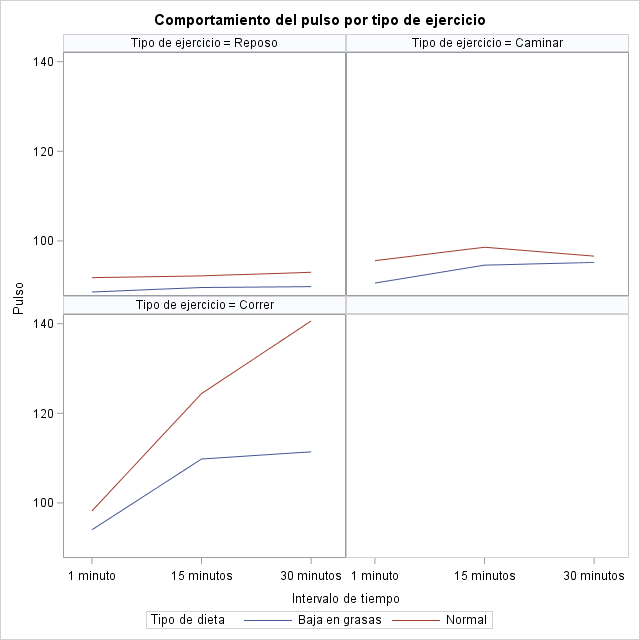
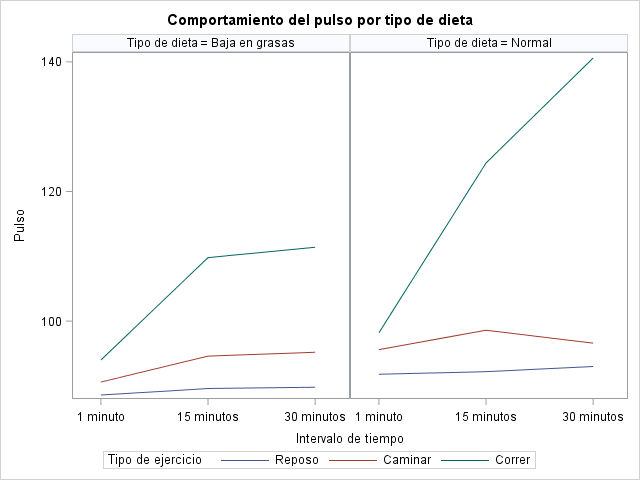
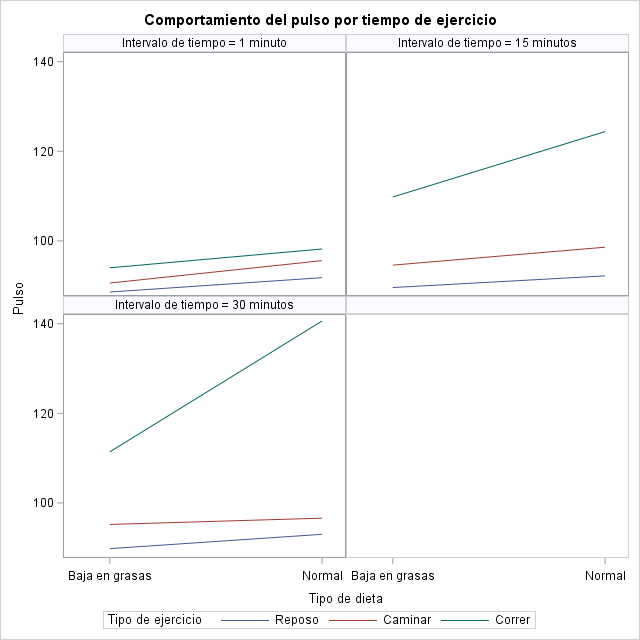

In [3]:
proc sgpanel data = datos;
panelby ejercicio;
vline tiempo / response = pulso group = dieta stat = mean;
title "Comportamiento del pulso por tipo de ejercicio";
run;

proc sgpanel data = datos;
panelby dieta;
vline tiempo / response = pulso group = ejercicio stat = mean;
title "Comportamiento del pulso por tipo de dieta";
run;
title;


proc sgpanel data = datos;
panelby tiempo;
vline dieta / response = pulso group = ejercicio stat = mean;
title "Comportamiento del pulso por tiempo de ejercicio";
run;
title;

Las gráficas señalan una posible interacción entre dieta y tiempo (sobre todo cuando el tipo de ejercicio es correr) y entre el tipo de ejercicio y el tiempo.

## Modelo de simetría compuesta

En este modelo, suponemos que existe una correlación constante en los tres periodos de tiempo, esto es lógico ya que como estamos midiendo la evolución de un mismo individuo, el pulso no es independiente.

El modelo propuesto para un individuo, que tomo la dieta $i$, ejercicio $j$ en el periodo $k$ es el siguiente:

$$y_{ijk} = \mu + D_i + E_j + T_k + DE_{ij}+DT_{ik}+ET_{jk}+DET_{ijk}\epsilon_{ijk}$$

donde $\epsilon_{ijk}\sim N(0,R)$ y 

$$R=\begin{bmatrix}{\sigma^2+\sigma^2_t }&{\sigma^2_t}&{\sigma^2_t}\\{\sigma^2_t}&{\sigma^2+\sigma^2_t}&{\sigma^2_t}\\{\sigma^2_t}&{\sigma^2_t}&{\sigma^2+\sigma^2_t}\end{bmatrix}$$

In [6]:
proc mixed data = datos order = data;
class persona dieta ejercicio tiempo;
model pulso =  dieta|ejercicio|tiempo;
repeated / subject = persona type = cs r rcorr;
store out = mcs;
run;


El procedimiento `proc mixed` realiza el análisis de medidas repetidas, se especifican los datos con la opción `data = datos` y le pedimos que ordene las categorías como aparecen en los datos con la opción  `order = data`.

Con `class persona dieta ejercicio tiempo;` se definen las variables categóricas en el modelo, esto es importante porque SAS construye las matrices diseño que usará en los modelos.

En la sentencia `model` se especifica que `pulso` es la variable respuesta, después del signo igual se especifican los efectos. La barra `|` indica todas las interacción entre los efectos efectos incluyendo los efectos principales.

Para especificar que es un modelo de medidas repetidas, usamos la sentencia `repeated` seguido de una barra inclinada. Indicamos con `subject = persona` que  a quien se le mide a través del tiempo es a la persona y finalmente le indicamos que el tipo de estructura de covarianza es la de simetría compuesta (compound symmetry) `type = cs` Para ver la matriz de correlación del pulso a través del tiempo para el individuo 1 usamos `rcorr` y `r` par ver su matriz de varianza covarianza.

Podemos guarda el modelo con la sentencia `store` lo nombraremos con `out = mcs`.


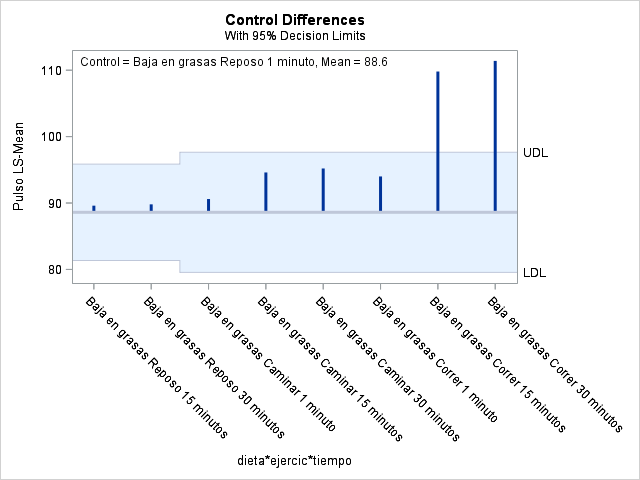
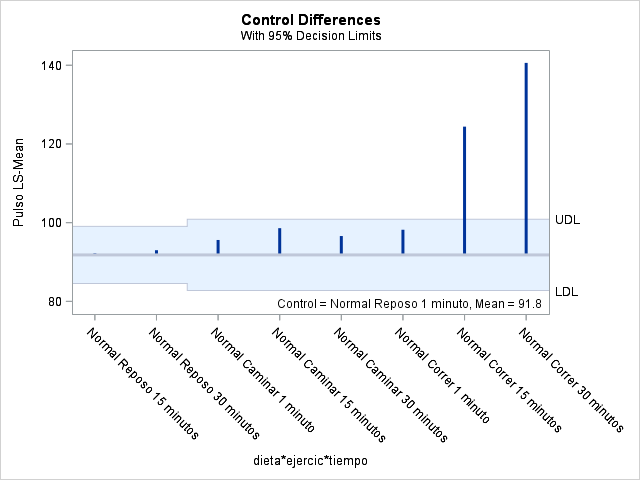
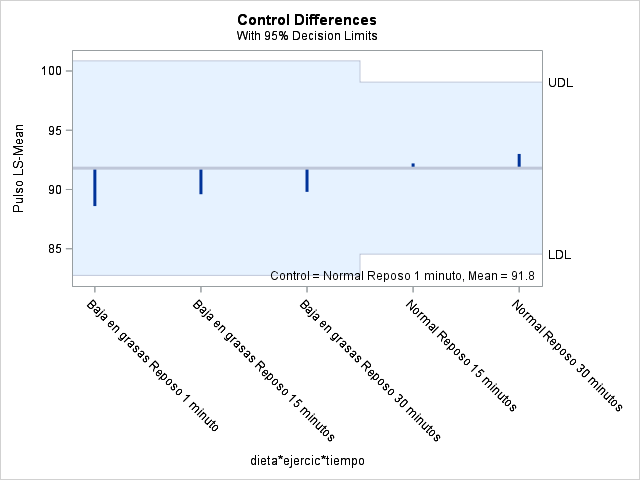
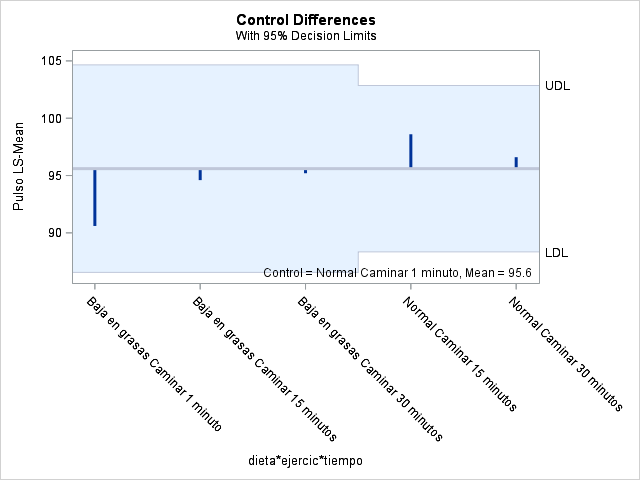
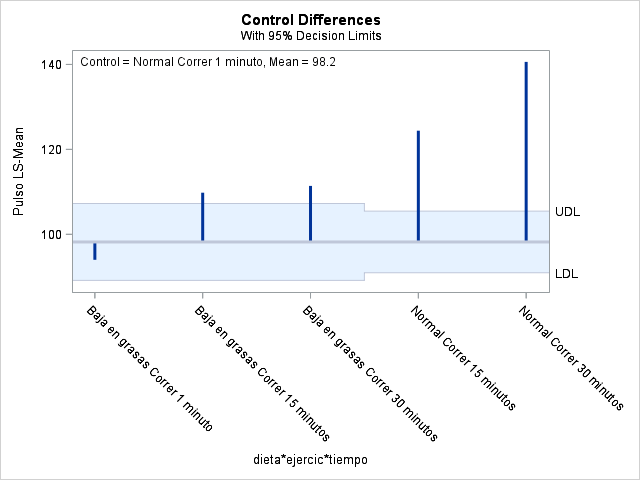
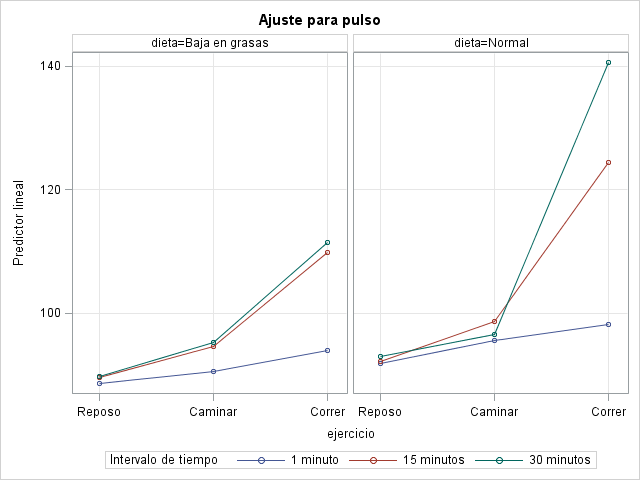

In [14]:
proc plm restore = mcs;
effectplot interaction(PLOTBY=dieta);
slice dieta*ejercicio*tiempo / sliceby (dieta ejercicio) pdiff=control("Normal" "Reposo" "1 minuto");
run;
